# Capstone project

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import geocoder 
import time
import seaborn as sns

CLIENT_ID = 'INSERT HERE' 
CLIENT_SECRET = 'INSERT HERE'

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction <a name="introduction"></a>

In this project, we perform a multivariate analysis of a dataset consisting of socio-economic, geographical and COVID-19 data in the 33 areas of London (32 Boroughs + City of London). Thus, we attempt to provide a comprehensive description of the currently on-going COVID-19 epidemic taking into account the various differences between boroughs. This analysis has relevance towards both retail businesses, who must decide on store openings in multiple regions facing heterogenous conditions, and for policy-makers, who similarly are faced with such issues when deciding on policy imlementation.

In the multivariate analysis, we will perform both cluster and factor analysis, which will be further explained in the relevant sections.

# Data 

Our final dataset will consists of the following variables : 
* Borough name and the statistical geography code as given by the ONS
* **COVID-19 Data** from a single period: total cases, total deaths and the death rate
* **Socio-Economic Data**: Population density (per HA, 2017), proportion of population aged 0-15 (2017), percentage of population from BAME groups (2016), Overseas nationals entering the UK (2015/16), modelled household median income estimates (2012/2013), median house price (2015), employment rate (2015)
* **Geographical Data**: Coordinate of the borough centre (latitutde and longitude), number of hospitals within a 5000m radius from the city centre

Giving a final dataset size of 33 rows x 15 columns



Socio-economic data 

In [2]:
df = pd.read_csv("london-borough-profiles.csv",encoding= 'unicode_escape')
df.drop(df.tail(5).index,inplace=True) 

In [3]:
varInterest = ['Code','Area_name','Population_density_(per_hectare)_2017','Proportion_of_population_aged_0-15,_2015','%_of_population_from_BAME_groups_(2016)','Overseas_nationals_entering_the_UK_(NINo),_(2015/16)','Modelled_Household_median_income_estimates_2012/13','Median_House_Price,_2015','Employment_rate_(%)_(2015)']
df = df[varInterest]
df['Modelled_Household_median_income_estimates_2012/13'] = df['Modelled_Household_median_income_estimates_2012/13'].str.replace(',', '').str.replace('£', '').astype(int)

Obtaining geographical coordinates of the different boroughs

In [4]:
from pykml import parser
filename='doc.kml'
with open(filename) as f:
    folder = parser.parse(f).getroot().Document.Folder

plnm=[]
cordi=[]
for pm in folder.Placemark:
    plnm1=pm.name
    plcs1=pm.Point.coordinates
    plnm.append(plnm1.text)
    cordi.append(plcs1.text)
    
db=pd.DataFrame()
db['place_name']=plnm
db['cordinates']=cordi

def dump(obj):
    for attr in dir(obj):
        if hasattr( obj, attr ):
            print( "obj.%s = %s" % (attr, getattr(obj, attr)))
#the kml output plnm1 and plcs1 are objects actually which can be viewed using the dump function from [SO](https://blender.stackexchange.com/questions/1879/is-it-possible-to-dump-an-objects-properties-and-methods)

db['Longitude'], db['Latitude'],db['value'] = zip(*db['cordinates'].apply(lambda x: x.split(',', 2)))

db.loc[-1] = ['City of London','-0.0922,51.5155,0','-0.0922','51.5155','0']
db.index = db.index + 1  
db.sort_index(inplace=True) 


In [5]:
df['Latitude'] = db['Latitude']
df['Longitude'] = db['Longitude']

Map of London

In [6]:
geolocator = Nominatim(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36")
location = geolocator.geocode('London, United Kingdom')
latitude = location.latitude
longitude = location.longitude
map_ldn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Area_name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_ldn)  

Foursquare data (number of hospitals)

In [7]:
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            "4bf58dd8d48988d196941735",
            CLIENT_ID, 
            CLIENT_SECRET, 
            "20180323", 
            lat, 
            lon, 
            10000
            )
        time.sleep(2)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

venues = getNearbyVenues(names=df['Area_name'], latitudes=df['Latitude'],longitudes=df['Longitude'])

In [8]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot.insert(0, 'Neighbourhood',venues['Neighbourhood'])

ven_onehot_grouped = venues_onehot.groupby('Neighbourhood').count().reset_index()


In [9]:
ven_onehot_grouped = ven_onehot_grouped[["Neighbourhood","Hospital"]]

df_ven = ven_onehot_grouped

COVID data

In [10]:
df_case = pd.read_csv("covidcase.csv")
df_death =pd.read_csv("coviddeath.csv")

df_covid = df_case.merge(df_death,on="Code").drop("Area_name;",axis=1)

Final Data Merging

In [11]:
df_final= df_covid.merge(df,on=["Code","Area_name"]).merge(df_ven,left_on="Area_name",right_on="Neighbourhood").drop("Neighbourhood",axis=1)

Final Dataset

In [12]:
df_final.shape

(33, 15)

In [13]:
df_final.head()

,Area_name,Code,Total_case,Deaths_total,Deaths_rate,Population_density_(per_hectare)_2017,"Proportion_of_population_aged_0-15,_2015",%_of_population_from_BAME_groups_(2016),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)",Modelled_Household_median_income_estimates_2012/13,"Median_House_Price,_2015",Employment_rate_(%)_(2015),Latitude,Longitude,Hospital
0,Barking and Dagenham,E09000002,668,165,143.0,57.9,27.2,49.5,"7,538",29420,243500,65.8,51.5607,0.1557,15
1,Barnet,E09000003,1543,453,139.7,44.9,21.1,38.7,"13,094",40530,445000,68.5,51.6252,-0.1517,21
2,Bexley,E09000004,997,228,98.6,40.3,20.6,21.4,"2,198",36990,275000,75.1,51.4549,0.1505,5
3,Brent,E09000005,1652,487,216.6,76.8,20.9,64.9,"22,162",32140,407250,69.5,51.5588,-0.2817,30
4,Bromley,E09000006,1479,340,106.1,21.8,19.9,18.9,"2,924",43060,374975,75.3,51.4039,0.0198,16


Map of london and the boroughs

In [14]:
map_ldn

# Methodology <a name="methodology"></a>

We carry out our analysis in three parts. 

Firstly, we carry out exploratory data analysis, using a heatmap to look a possible correlations within the different variables in our dataset.

Secondly, a non-hierarchical k-means clustering algorithm is used to group the given group data points into predefined clusters. We face two issues before implementation. Before we implement the algorithm, it is prudent to standardise the data, which we shall do using the Min-Max Scaler in the sklearn library. We also have to decide on the number of clusters used in the division of data. We will use an elbow data chart to aid us in a decision. 

Finally, factor analysis will be carried out. Before this is done, we need to verify the sampling adaquecy. We use both the Kaiser-Meyer-Olkin statistic and the Bartlett's test of sphericity. 

# Analysis <a name="analysis"></a>

As mentioned, we firstly carry out exploratory data analysis using a heatmap to identify possible correlations.

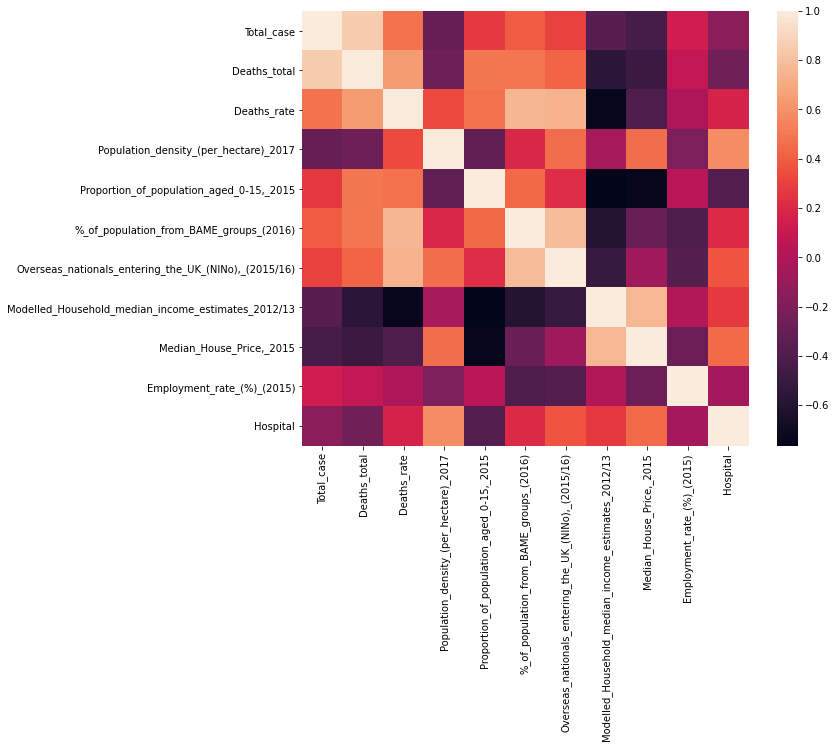

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score

df_features = df_final.drop(["Area_name","Code","Longitude","Latitude"],axis=1)
df_features["Overseas_nationals_entering_the_UK_(NINo),_(2015/16)"] = df_features["Overseas_nationals_entering_the_UK_(NINo),_(2015/16)"].str.replace(',', '')
df_fa = df_features.copy()

plt.figure(figsize=(10,8))
corrMatrix = df_features.astype(float).corr()
sns.heatmap(corrMatrix)

Overall, we identify the following sets of correlations. As expected, economic indicators, such as median house price and median household income, are strongly negatively correlated with the various COVID-19 indicators. Hence, this correlation confirms our usual intuition that poorer regions are disproportionately affected by the pandemic. 

Similarly, social indicators, such as proportion of youths, percentage of BAME and number of overseas nationals are highly correlated with COVID-19 indicators. Interestingly, the population density seems to be negatively correlated with COVID-19 indicators.

Cluster Analysis

Next, we carry out the k-means clustering algorithm. However, before that, we need to carry out the feature normalisation and the identifaction of the number of clusters to use.

To identify the number of clusters, we use both the traditional elbow method and the Silhouette score.

In [16]:
features = MinMaxScaler().fit_transform(df_features)
features_fa = features.copy()

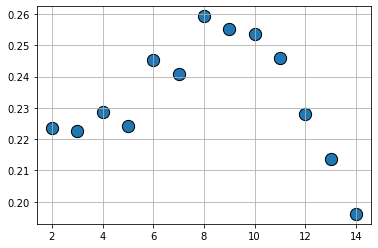

In [17]:
km_silhouette = []
km_scores = []
for i in range(2,15):
    km = KMeans(n_clusters=i, random_state=0).fit(features)
    preds = km.predict(features)
    
    silhouette = silhouette_score(features,preds)
    km_silhouette.append(silhouette)
    km_scores.append(-km.score(features))
    
    
plt.scatter(x=[i for i in range(2,15)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.show()

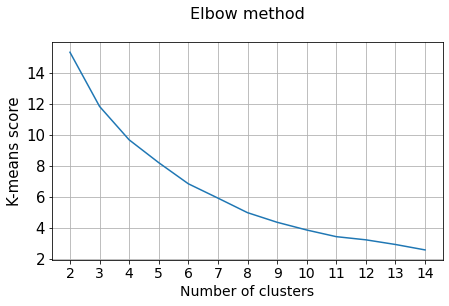

In [18]:
plt.figure(figsize=(7,4))
plt.title("Elbow method\n",fontsize=16)
plt.plot([i for i in range(2,15)],km_scores)
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,15)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Quite clearly, the elbow method and the Silhouette coefficient both indicate that k=9 is the optimal number of cluster. While the elbow method is less obvious, as it seems like k=4 could be a candidate as well, the silhouette coefficient optimality is clear as day. 

Given the low silouette coefficient, this indicates a possible weak structure in the data, thus motivating our usage of factor analysis in the next section.

We continue on to carry out the algorithm with k=9.

In [19]:
km = KMeans(n_clusters=9, init='random', n_init=1, max_iter=300, random_state=0)
km.fit(features)
df_final['classification'] = km.labels_.tolist()

We provide a map showing the classification for each of the borough, as well as the borough in one particular cluster. 

In [20]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim 
import folium


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Area_name'], df_final['classification']):
    folium.CircleMarker(
        [lat, lon],
        popup=folium.Popup(str(poi) + 'Cluster ' + str(int(cluster) +1)),
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(map_clusters)
        
map_clusters

In [21]:
df_final.loc[df_final['classification'] == 1]

,Area_name,Code,Total_case,Deaths_total,Deaths_rate,Population_density_(per_hectare)_2017,"Proportion_of_population_aged_0-15,_2015",%_of_population_from_BAME_groups_(2016),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)",Modelled_Household_median_income_estimates_2012/13,"Median_House_Price,_2015",Employment_rate_(%)_(2015),Latitude,Longitude,Hospital,classification
18,Kensington and Chelsea,E09000020,533,124,95.2,131.1,16.4,30,"7,237",55620,1200000,68.2,51.502,-0.1947,30,1
32,City of London,E09000001,774,4,42.6,30.3,11.4,27.5,975,63620,799999,64.6,51.5155,-0.0922,30,1


Factor Analysis

Given the weak structure of our data in clustering, we move on to factor analysis to identify a possible set of underlying variables for the observed data. However, before that we carry out two test to ensure the suitability of the data.

In [22]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(features_fa)
chi_square_value, p_value

(311.41694870017494, 7.122345184415977e-38)

In [23]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(features_fa)
kmo_model

/home/shem/anaconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.67765742409689

The KMO value at ~0.65 is fairly decent, while the p-value for Bartlett's test is highly significant. We move on to obtaining a scree plot to identify the number of factors to use.

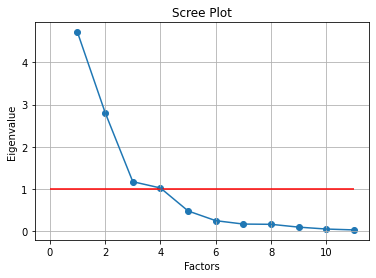

In [24]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.fit(features_fa, 25)

ev, v = fa.get_eigenvalues()

# Create scree plot using matplotlib
plt.figure(figsize=(6,4))
plt.scatter(range(1,features_fa.shape[1]+1),ev)
plt.plot(range(1,features_fa.shape[1]+1),ev)
plt.hlines(1, 0, features_fa.shape[1], colors='r')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

The usual cut-off used is to identify factors with an eigenvalues of greater than 1, as this indicates that the factor accounts for at least as much variance as a single variable. The factors at k=3 also confirms with our own theoretical intuition that the variables are broadly classified into such categories.

Next, we carry out the analysis, using the default method of MINRES (similar to the standard OLS method for factor extraction) and we specify to use the common varimax rotation.

In [31]:
fa = FactorAnalyzer()
fa.set_params(n_factors=3, rotation="varimax")
fa.fit(features_fa,25)
loadings = pd.DataFrame(fa.loadings_)
loadings.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
loadings.index = df_fa.columns

In [32]:
loadings

,Factor-1,Factor-2,Factor-3
Total_case,0.148974,-0.110044,0.948953
Deaths_total,0.395125,-0.020667,0.841894
Deaths_rate,0.523983,0.557680,0.495837
Population_density_(per_hectare)_2017,-0.182313,0.756358,-0.196170
"Proportion_of_population_aged_0-15,_2015",0.840170,-0.107072,0.180815
%_of_population_from_BAME_groups_(2016),0.457884,0.609989,0.400495
"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)",0.274837,0.811123,0.376971
Modelled_Household_median_income_estimates_2012/13,-0.914954,-0.209183,-0.241749
"Median_House_Price,_2015",-0.801844,0.321274,-0.277435
Employment_rate_(%)_(2015),0.013777,-0.366926,0.070114


In [35]:
segments = loadings[loadings >= 0.4].fillna(loadings[loadings <= -0.4])
segments

,Factor-1,Factor-2,Factor-3
Total_case,NaN,NaN,0.948953
Deaths_total,NaN,NaN,0.841894
Deaths_rate,0.523983,0.557680,0.495837
Population_density_(per_hectare)_2017,NaN,0.756358,NaN
"Proportion_of_population_aged_0-15,_2015",0.840170,NaN,NaN
%_of_population_from_BAME_groups_(2016),0.457884,0.609989,0.400495
"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)",NaN,0.811123,NaN
Modelled_Household_median_income_estimates_2012/13,-0.914954,NaN,NaN
"Median_House_Price,_2015",-0.801844,NaN,NaN
Employment_rate_(%)_(2015),NaN,NaN,NaN


We classify the 3 factors based on the variables identified within each factor. Broadly, they are: Socio-Economic, Socio-Demographic, and COVID-19 factors.

In [34]:
pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])

,0,1,2
Variance,3.095470,2.572976,2.370473
Proportional Var,0.281406,0.233907,0.215498
Cumulative Var,0.281406,0.515313,0.730811


To conclude, we check the variance explained from the 3 factors. Altogether, they explain 73% of the variance, which is a good portion.

# Results and Discussion <a name="results"></a>

London, as a region of nearly 10 million people, contains a varied and heterogenous population. In our dataset containing a broad mix of different socio-economic and demographics data, across the 33 areas of London, we hoped to caputure, to a certain extent, the heterogeneity of the different areas, and thus be able to provide a description of firstly, the heterogeneities between the boroughs, and secondly, to extract the underlying factors that described these heterogeneities. These two issues were tackled with our cluster analysis and factor analysis respectively.

Our cluster analysis results indicated to us that it was possible to classify the boroughs into 9 different clusters, which were, unsurprisingly, strongly spatially dependent as can be seen from our map. We expect that areas which are closer together would exhibit similar characteristics, and hence, be classified into similar clusters. 

Our factor analysis result indicated to us that variables could broadly be classified into 3 different factors, which further confirms our theoretical classificaiton of the variables, and these are broadly, socio-economic, socio-demographic and COVID-19 related data. 

For further analysis, we recommend the usage of more comprehensive socio-economic data, and the integration of temporal data, which would allow us to observe the evolution of these heterogeneity over time. Due to our limited resources, we were not able to carry out such analysis in this project.

# Conclusion <a name="conclusion"></a>

Our analysis provided both cluster and factor analysis on a broad dataset in London. Given our usage of current COVID-19 data, we hope this will support and inform businesses and policy-makers in their decisions.